In [1]:
import re
import os
import numpy as np
import pandas as pd

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
master_file = "/data5/deepro/starrseq/papers/reproducibility/0_in-house_dataset/data/master/master.bed"
depth_file = "/data5/deepro/starrseq/papers/reproducibility/3_read_lib_qc/data/in_house/cov/meta_cov.csv"
lib_names = ["IN", "CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [4]:
def tpm_normalize(df):
    # get length of regions in kilobases
    length = (df.index.get_level_values("end") - df.index.get_level_values("start"))/1e3
    # get per million scaling factor
    pmscale = df.sum()/1e6
    df = df.div(length, axis=0).div(pmscale)
    return df
    


def create_depth_df(master_file, depth_file):
    master_df = pd.read_csv(master_file, sep="\t", header=None, usecols=[0,1,2], names=["chr", "start", "end"])
    depth_df = pd.read_csv(depth_file)
    df = pd.concat((master_df, depth_df), axis=1)
    df = df.set_index(["chr", "start", "end"])
    df = tpm_normalize(df)
    # get mean tpm per regions
    category_dict = dict(zip(df.columns, [re.sub(r'_R\d', '', c) for c in df.columns]))
    df = df.groupby(df.columns.map(category_dict.get), axis=1).mean()
    return df

In [5]:
df = create_depth_df(master_file, depth_file)

In [6]:
plot_df = df.melt(var_name="library", value_name="TPM normalized reads distribution")

In [7]:
df.describe()

,16P12_1,ATF2,CC,CTCF,FOXA1,IN,LEF1,SCRT1,TCF7L2
count,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000
mean,28.748559,28.970338,28.666493,28.695188,28.414909,29.400135,28.752046,28.620475,28.539842
std,30.155695,28.473524,30.264636,27.031523,42.792454,14.619222,32.171040,33.278167,38.375079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.405915,16.063811,13.743358,14.247130,12.145651,20.133234,13.937130,13.838966,12.704923
50%,22.460741,24.446816,22.000336,22.560734,19.601794,27.715988,22.177119,21.843481,20.507798
75%,34.271431,36.042922,34.461026,35.193396,31.787160,36.468821,34.488068,33.838673,32.836919
max,1121.624654,2828.655409,1229.132647,1077.384872,1742.328441,393.243305,1504.988931,1356.505867,1653.640332


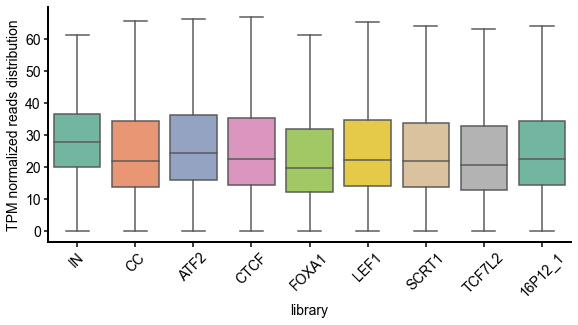

In [8]:
ax = sns.catplot(
    data=plot_df, 
    y="TPM normalized reads distribution", 
    x="library", 
    palette="Set2", 
    height=4, 
    aspect=2, 
    kind="box", 
    showfliers=False,
    order=lib_names,
    )
ax.set_xticklabels(rotation=45);

In [14]:
save_file = "../data/figures/read_depth.pdf"
save_pdf(save_file, ax.fig)